<a href="https://colab.research.google.com/github/lexmar07/Weekly_GDP_level_tracker/blob/main/GDP_level_weekly_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weekly GDP level tracker (from OECD data)

**Abstract:** The code visualizes the evolution of the Eurozone's GDP-**level**  index  based on the Year-On-Year OECD weekly tracker (https://www.oecd.org/economy/weekly-tracker-of-gdp-growth/).

## Technicalities:

The existing OECD tracker provides only YOY \% change of GDP (weekly time-series  data, is denoted below by $100 \times x_t$). To get the GDP in levels, one needs to solve the following difference equation:   

$$(y_t - y_{t-k})/y_{t-k} = x_t,$$
where $x_t$ is the change in GDP  and $y_t$ is the GDP level.
Parameter $k$  stands for the number of weeks per year.
For simplicity, we set  $ k = 52$. 


Then taking logs we obtain $\ln(y_t) - \ln(y_{t-k}) = \ln(x_t +1)$. Denoting  $\ln(y_t)$ by $a_t$ and $\ln(x_t +1)$  by $d$, the latter equation can be rewritten as $(1-L^k)a = d$, where $L$ stands for the standard lag operator.
Its solution is given by $a_t = (1-L^k)^{-1}d_t = \sum\limits_{j=0}^\infty d_{t-kj}$.

Cutting the summation at index $0$ (the baseline year), we obtain:

$
a_t = \begin{cases}
d_{0} + d_{k} + d_{2k}\dots +d_{t}, \text{if  $t \equiv 0$  mod  $k$,}\\
d_{1} + d_{k+1} + d_{2k+1}\dots +d_{t}, \text{if  $t \equiv 1$ mod  $k$,}\\
\dots\\
d_{k-1} + d_{2k-1} + d_{3k-1}\dots +d_{t}, \text{if  $t \equiv k-1$ mod $k$.}
\end{cases}
$


Resulting that  $y_t = y_{t \text{ mod } k} \cdot \exp(a_t).$
We can use some baseline data to calibrate the initial multiplicative constants $y_{t \text{ mod } k}$. Here we use monthly data in the laminar period (2018)  and linearly interpolate it to get $k$  initial (week period) numbers.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## Step 0: Download the data and select the Eurozone.

In [ ]:
# Download YOY weekly data from https://www.oecd.org/economy/weekly-tracker-of-gdp-growth/
url = "https://github.com/NicolasWoloszko/OECD-Weekly-Tracker/raw/main/Data/weekly_tracker.xlsx"
df = pd.read_excel(url)

# Download Monthly GDP-level data from https://fred.stlouisfed.org/series/EA19LORSGPNOSTSAM
"""
Units:
Index,
Seasonally Adjusted (?)
""" 

url2 = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=off&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=EA19LORSGPNOSTSAM&scale=left&cosd=2018-07-01&coed=2022-02-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2022-08-16&revision_date=2022-08-16&nd=1960-03-01"
df_monthly = pd.read_csv(url2)


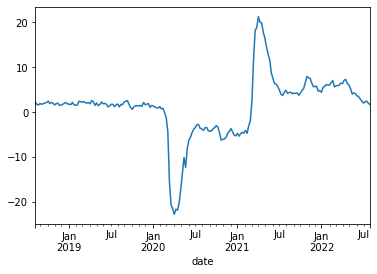

In [ ]:
# Eurozone only
df_euro = df[df["region"] == "Eurozone"] 

# plot data, 
# one can see the effect of the COVID - "low base" for the YOY data: the sharp increase of GDP in March 2021
dataset = df_euro.pivot(index='date',columns='region')[['Tracker (yoy)']]
dataset.iloc[:, 0].plot(x ='date', y='')


## Step 1: From % change to $x_t$, and define $d_t$

In [ ]:


# no % variation
dataset = dataset/100
#x_t + 1 
dataset += 1 
#dataset.describe()
#ln(x_t + 1) 
d = np.log(dataset) 


## Step 2: Define and visualize  $\ln(y_t)-\ln(y_0) = d_t$

In [ ]:
k = 52
# a = pd.DataFrame(np.zeros_like(d)) 
a = d*0 
for x in range(dataset.shape[0]):
    for y in range(dataset.shape[1]):
        for j in range(x):
            if x - j*k > 0 : 
                a.iloc[x,y] += d.iloc[x - j*k,y]
            else:
                break

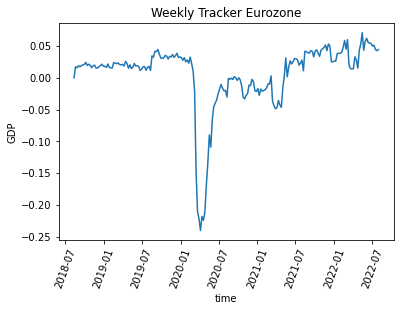

In [ ]:
for k in range(dataset.shape[1]):
    lngdp = a.iloc[:, k]
    plt.plot(lngdp)
    plt.xlabel('time')
    plt.ylabel('GDP')
    plt.title('Weekly Tracker Eurozone')
    plt.xticks(rotation=70)

## Step 3: Visualize $y_t = y_{t \text{ mod } k} \cdot exp(a_t), $ with $y_{t \text{ mod } k} \equiv 1$

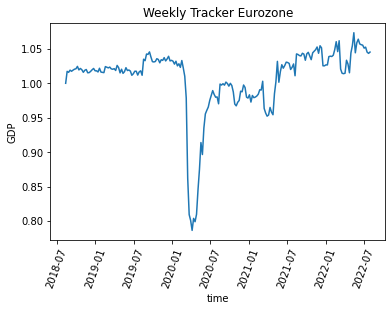

In [ ]:
y_no_init = np.exp(a) # improper initialization

for k in range (y_no_init.shape[1]):
    gdp = y_no_init.iloc[0:210, k] 
    plt.plot(gdp)
    plt.xlabel('time')
    plt.ylabel('GDP')
    plt.title('Weekly Tracker Eurozone')
    plt.xticks(rotation=70)

# Step 4: Get values of  $y_{t \text{ mod } k}$ from the monthly GDP data

We need to initialize correctly $k$ initial values $y_{t \text{ mod } k}$. To do so we use 2018 monthly data  and linearly interpolate to get weekly data. We assume that absence of large shocks in 2018 makes this approach reasonable. 

In [ ]:
DATE = pd.date_range(start='2018-08-12',   periods=13, freq='MS') # end ='2019-08-01',
df_monthly['DATE'] =  pd.to_datetime(df_monthly['DATE'])
df_monthly['DATE'] =  df_monthly['DATE'].dt.to_period('M')

df_weekly_interpolated = df_monthly.set_index('DATE').resample('W').interpolate(method='linear')

In [ ]:
y = y_no_init.copy()

for k in range (y.shape[1]):
    init_vals = df_weekly_interpolated.iloc[0:52, k] 
    for x in range(dataset.shape[0]):
        y.iloc[x, k]  = y_no_init.iloc[x, k] * init_vals[x%52]


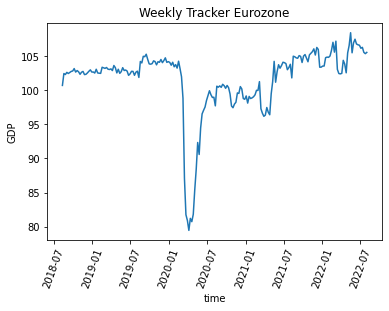

In [ ]:
# visualize
for k in range (y.shape[1]):
    gdp = y.iloc[0:210, k] 
    plt.plot(gdp)
    plt.xlabel('time')
    plt.ylabel('GDP')
    plt.title('Weekly Tracker Eurozone')
    plt.xticks(rotation=70)

# CheckSum: Compare with monthly data

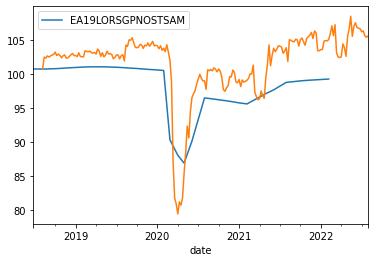

In [ ]:
ax = df_monthly.plot(x='DATE', y=['EA19LORSGPNOSTSAM'])

gdp = y.iloc[0:210, 0]

gdp.plot(x='date', y='', ax=ax)




It seems weekly data starts from slightly too low value + we use seasonally adjusted monthly data (to change for row), but overall trend is preserved.

In [13]:
gdp # gdp-index

date
2018-08-12    100.721619
2018-08-19    102.465659
2018-08-26    102.320928
2018-09-02    102.637676
2018-09-09    102.470820
                 ...    
2022-07-03    106.173751
2022-07-10    106.312048
2022-07-17    105.574776
2022-07-24    105.383583
2022-07-31    105.568908
Name: (Tracker (yoy), Eurozone), Length: 208, dtype: float64